In [1]:
%matplotlib inline
from IPython.display import clear_output
import os
from copy import deepcopy

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from models import ConvNet
from helper import ExperimentLogger, display_train_stats
from fl_devices import Server, Client
from data_utils import split_noniid, CustomSubset

from sklearn.cluster import AgglomerativeClustering

from data_loaders import make_train_data, PecanStreetDataset
import config_file
from clean_data_seq2point import load_all_houses_with_device, create_activations
from lstm_seq2point import LSTM



torch.manual_seed(42)
np.random.seed(42)

We will run experiments with the EMNIST data set of handwritten characters. We simulate a scenario with 10 clients and distribute the data among the clients in a non-iid way accoding to a dirichlet distribution parametrized with alpha=1.0 . The distribution of data is shown below.

In [2]:
# N_CLIENTS = 5
# DIRICHLET_ALPHA = 1.0


# data = datasets.EMNIST(root=".", split="byclass", download=True)

# mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
#        'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
#        'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c',
#        'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
#        'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1')

# idcs = np.random.permutation(len(data))
# train_idcs, test_idcs = idcs[:10000], idcs[10000:20000]
# train_labels = data.train_labels.numpy()

# client_idcs = split_noniid(train_idcs, train_labels, alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS)

# client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
# test_data = CustomSubset(data, test_idcs, transforms.Compose([transforms.ToTensor()]))

In [3]:
config_ = config_file.load_hyperparameters("refrigerator1")

In [4]:
homes = load_all_houses_with_device(config_file.path_2, config_['appliance'])

In [5]:
test_homes = homes.dataid.unique()[0:3]

In [6]:
root_path = "/Users/alfredorodriguez/Desktop/input/1min_real_sept2019.csv"

In [7]:
root_path_2 = "/Users/alfredorodriguez/Desktop/input/1min_real_oct2019.csv"

In [8]:
client_data = [PecanStreetDataset(root_path, 'refrigerator1', 249, [i]) for i in test_homes]

In [9]:
test_data = PecanStreetDataset(root_path_2, 'refrigerator1', 249, [test_homes[0]]) 


In [10]:
# test_data = DataLoader(dataset = test_data, batch_size=128,
#                       shuffle=False, num_workers=0)

In [11]:
# client_data = [DataLoader(dataset = i, batch_size=config_['batch_size'],
#                       shuffle=False, num_workers=0) for i in client_data]

In [12]:
client_data[0]

In [13]:
test_data

In [14]:
# plt.figure(figsize=(20,3))
# plt.hist([train_labels[idc]for idc in client_idcs], stacked=True, 
#          bins=np.arange(min(train_labels)-0.5, max(train_labels) + 1.5, 1),
#         label=["Client {}".format(i) for i in range(N_CLIENTS)])
# plt.xticks(np.arange(62), mapp)
# plt.legend()
# plt.show()

Next, we simulate a clustering structure in the client population, by rotating the data for half of the first 5 clients by 180 degree. We display 10 data samples from the 1st and the 6th client for illustration.

In [15]:
# for i, client_datum in enumerate(client_data):
#     if i<5:
#         client_datum.subset_transform = transforms.Compose([transforms.RandomRotation((180,180)),
#                                                       transforms.ToTensor()])
#     else:
#         client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

In [16]:
clients = [Client(LSTM(
        config_['in_channels'],
        config_['out_channels'],
        config_['kernel_size'],
        config_['hidden_size_1'],
        config_['hidden_size_2'],
        config_['fc1'],
        config_['batch_size'],
        config_['window_size']), lambda x : torch.optim.AdamW(x, lr=3.3180899699083407e-04, weight_decay = 0), dat, idnum=i) 
           for i, dat in enumerate(client_data)]
server = Server(LSTM(
        config_['in_channels'],
        config_['out_channels'],
        config_['kernel_size'],
        config_['hidden_size_1'],
        config_['hidden_size_2'],
        config_['fc1'],
        config_['batch_size'],
        config_['window_size']
    ), test_data)

In [17]:
client_data[0]

In [18]:
len(client_data[0])

41760

In [19]:
# for client in [clients[0], clients[4]]:
#     x, y = iter(client.train_loader).next()

#     print("Client {}:".format(client.id))
#     plt.figure(figsize=(15,1))
#     for i in range(10):
#         plt.subplot(1,10,i+1)
#         plt.imshow(x[i,0].numpy().T, cmap="Greys")
#         plt.title("Label: {}".format(mapp[y[i].item()]))
#     plt.show()

Now everything is set up to run our Clustered Federated Learning algorithm. During training, we will track the mean and std client accuracies, as well as the average and maximum client update norms.

In [20]:
#differences with my code: clients and server objects
#with client, I pretty much do the same thing except for:
#track id, track weights, calculate and track weight differences

#with server object, things I don't yet do:
#compute pairwise similarities, cluster clients based on cosine similarity, aggregate based on clusters, compute max
#update norm, compute mean update norm, cache model

#

clients[0]

In [21]:
len(clients)

3

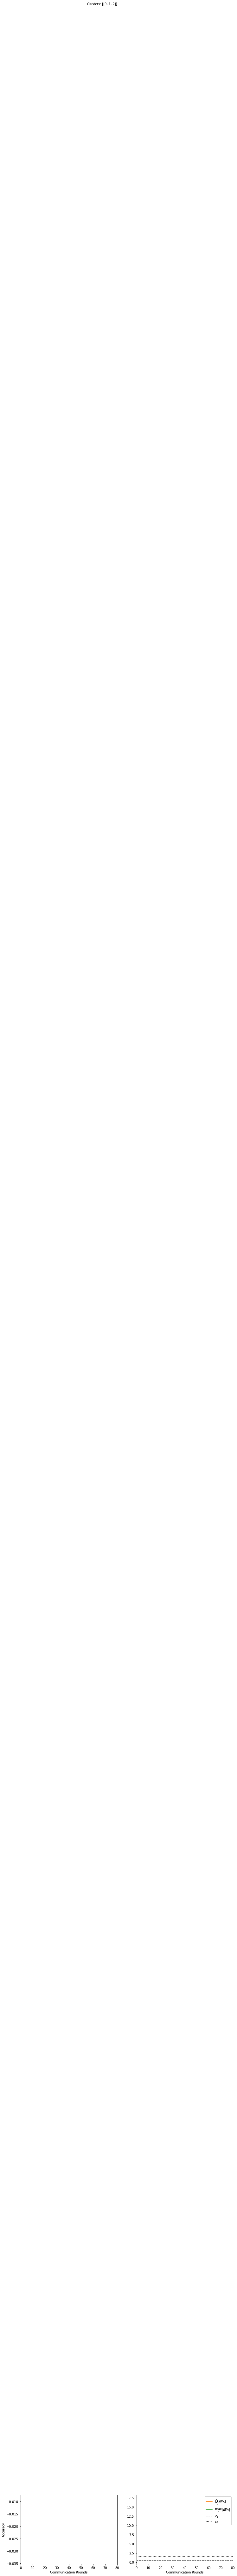

KeyboardInterrupt: 

In [22]:
COMMUNICATION_ROUNDS = 80
EPS_1 = 0.4
EPS_2 = 1.6
    
    
cfl_stats = ExperimentLogger()
    
cluster_indices = [np.arange(len(clients)).astype("int")]
client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]


for c_round in range(1, COMMUNICATION_ROUNDS+1):

    if c_round == 1:
        for client in clients:
            client.synchronize_with_server(server)
            
    participating_clients = server.select_clients(clients, frac=1.0)

    for client in participating_clients:
        client.compute_weight_update(epochs=1)
        client.reset()

    similarities = server.compute_pairwise_similarities(clients)

    cluster_indices_new = []
    for idc in cluster_indices:
        max_norm = server.compute_max_update_norm([clients[i] for i in idc])
        mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])
        if mean_norm<EPS_1 and max_norm>EPS_2 and len(idc)>2 and c_round>20:
            server.cache_model(idc, clients[idc[0]].W, acc_clients)
            
            c1, c2 = server.cluster_clients(similarities[idc][:,idc]) 
            cluster_indices_new += [c1, c2]
             
            cfl_stats.log({"split" : c_round})

        else:
            cluster_indices_new += [idc]
        
    cluster_indices = cluster_indices_new
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

    server.aggregate_clusterwise(client_clusters)

    acc_clients = [client.evaluate() for client in clients]
    
    cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : mean_norm, "max_norm" : max_norm,
                  "rounds" : c_round, "clusters" : cluster_indices})
    
    
    display_train_stats(cfl_stats, EPS_1, EPS_2, COMMUNICATION_ROUNDS)

    
for idc in cluster_indices:    
    server.cache_model(idc, clients[idc[0]].W, acc_clients)

The training process resulted in multiple models for every client: A Federated Learning base model as well as more specialized models for the different clusters.  We can now compare their accuracies on the clients' validation sets, and assign each client the model which performed best.

In [ ]:
results = np.zeros([10, len(server.model_cache)])
for i, (idcs, W, accs) in enumerate(server.model_cache):
    results[idcs, i] = np.array(accs)

As we can see, clustering improoved the accuracy for all clients by about 10%.

In [ ]:
frame = pd.DataFrame(results, columns=["FL Model"]+["Model {}".format(i) 
                                                    for i in range(results.shape[1]-1)],
            index = ["Client {}".format(i) for i in range(results.shape[0])])

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
frame.T.style.apply(highlight_max)

In [23]:
model = torch.nn.Sequential(
    torch.nn.Linear(3, 1),
    torch.nn.Flatten(0, 1)
)

In [25]:
model_2 = torch.nn.Sequential(
    torch.nn.Linear(3, 1),
    torch.nn.Flatten(0, 1)
)

In [45]:
model.state_dict() - model_2.state_dict()

TypeError: unsupported operand type(s) for -: 'collections.OrderedDict' and 'collections.OrderedDict'

In [39]:
model.state_dict().values()

odict_values([tensor([[ 0.1965, -0.0740, -0.4214]]), tensor([0.2037])])

In [41]:
model_outputs = list(zip(model.state_dict(), model_2.state_dict()))

In [49]:
res = {key: model_2.state_dict()[key] - model.state_dict().get(key, 0)
                       for key in model_2.state_dict().keys()}

In [50]:
res

{'0.weight': tensor([[-0.1343, -0.1435,  0.7005]]), '0.bias': tensor([0.2760])}

In [51]:
model.state_dict()

OrderedDict([('0.weight', tensor([[ 0.1965, -0.0740, -0.4214]])),
             ('0.bias', tensor([0.2037]))])

In [52]:
model_2.state_dict()

OrderedDict([('0.weight', tensor([[ 0.0622, -0.2175,  0.2791]])),
             ('0.bias', tensor([0.4797]))])

In [54]:
model_list1 = [model, model_2]

In [58]:
model_list2 = [model, model_2]

In [65]:
weight_deltas = [{key: model_list1[i].state_dict()[key] - model_list2[i].state_dict().get(key, 0)
                       for key in model_list1[i].state_dict().keys()} for i in range(len(model_list1))]

In [60]:
train_buildings = [12,34,354,456,34]

In [61]:
cluster_indices = [np.arange(len(train_buildings)).astype("int")]
client_clusters = [[train_buildings[i] for i in idcs] for idcs in cluster_indices]

In [62]:
client_clusters

[[12, 34, 354, 456, 34]]

In [63]:
cluster_indices

[array([0, 1, 2, 3, 4])]

In [70]:
flat = [item for subitem in weight_deltas for item in subitem]

In [150]:
good_list = [list(weight_deltas[i].values()) for i in range(len(weight_deltas))]

In [153]:
flat = [item for subitem in good_list for item in subitem]

In [157]:
flat

[tensor([[0., 0., 0.]]), tensor([0.]), tensor([[0., 0., 0.]]), tensor([0.])]

In [107]:
for i in weight_deltas[0].values():
    print(i)
    if len(i) > 1:
        flat = [item for subitem in i for item in subitem]
        print(flat)

tensor([[0., 0., 0.]])
tensor([0.])


In [108]:
len([[0,0,0]])

1

In [109]:
len([0])

1

In [232]:
models1 = [ConvNet(), ConvNet()]

In [233]:
models2 = [ConvNet(), ConvNet()]

In [234]:
models1 = [deepcopy(model.state_dict()) for model in models1]

In [235]:
models2 = [deepcopy(model.state_dict()) for model in models2]

In [236]:
weight_deltas = [{key: models2[i][key] - models1[i].get(key, 0)
                       for key in models2[i].keys()} for i in range(len(models2))]

In [241]:
models2

[OrderedDict([('conv1.weight',
               tensor([[[[ 1.3517e-01,  2.5685e-02,  1.5951e-01,  7.4341e-02, -9.0724e-02],
                         [ 1.5374e-01,  1.5845e-01, -1.1826e-01, -1.1354e-01,  1.4153e-02],
                         [ 1.5756e-01,  1.1342e-01,  1.7078e-01, -1.8056e-01,  5.0564e-02],
                         [ 1.3153e-01, -5.1036e-02,  1.0470e-01, -1.3721e-01,  1.0781e-01],
                         [-1.9759e-01,  4.0499e-02, -6.0095e-02,  1.2198e-01, -1.0794e-01]]],
               
               
                       [[[ 1.2547e-01,  1.6710e-01, -1.1692e-01,  1.7465e-01,  1.6174e-01],
                         [-1.2523e-01,  1.9605e-01,  5.9531e-02, -6.8591e-02, -1.2299e-02],
                         [-5.9229e-02, -6.7217e-02,  6.6279e-02, -1.3877e-01,  1.7345e-01],
                         [-1.9021e-01,  2.4061e-02,  4.7827e-02,  1.4771e-01,  1.1924e-02],
                         [-3.9427e-03,  4.9164e-02,  1.2831e-01, -2.1003e-02,  9.2307e-02]]],
             

In [242]:
models1

[OrderedDict([('conv1.weight',
               tensor([[[[ 0.0638,  0.1532, -0.0032, -0.0279,  0.1304],
                         [-0.0740, -0.0085, -0.0502, -0.1573, -0.0063],
                         [-0.1058,  0.1784, -0.0263,  0.1496, -0.1982],
                         [-0.0162, -0.1139,  0.0470,  0.0990, -0.1096],
                         [ 0.0019, -0.1535, -0.1275, -0.0884, -0.1506]]],
               
               
                       [[[-0.0630, -0.1066, -0.0702, -0.1056,  0.0020],
                         [ 0.1524,  0.1818, -0.0203, -0.0663,  0.1448],
                         [-0.1181, -0.1199,  0.0631,  0.0137, -0.0493],
                         [ 0.0623, -0.1910,  0.1487, -0.0616, -0.1049],
                         [-0.0064,  0.1907,  0.0676,  0.1651,  0.0630]]],
               
               
                       [[[-0.0609, -0.0029,  0.0193,  0.1939, -0.0941],
                         [-0.0534,  0.1070,  0.1582, -0.0461,  0.1032],
                         [-0.1783,  0

In [239]:
weight_deltas

[{'conv1.weight': tensor([[[[ 0.0713, -0.1275,  0.1627,  0.1023, -0.2211],
            [ 0.2277,  0.1670, -0.0681,  0.0438,  0.0204],
            [ 0.2634, -0.0650,  0.1971, -0.3302,  0.2488],
            [ 0.1478,  0.0628,  0.0577, -0.2362,  0.2174],
            [-0.1995,  0.1940,  0.0674,  0.2104,  0.0427]]],
  
  
          [[[ 0.1885,  0.2737, -0.0467,  0.2802,  0.1597],
            [-0.2776,  0.0143,  0.0799, -0.0023, -0.1571],
            [ 0.0588,  0.0526,  0.0032, -0.1525,  0.2228],
            [-0.2526,  0.2151, -0.1009,  0.2093,  0.1168],
            [ 0.0024, -0.1415,  0.0607, -0.1861,  0.0293]]],
  
  
          [[[ 0.2591,  0.1314, -0.1783, -0.1489,  0.0380],
            [ 0.0703, -0.2740, -0.2773,  0.0655, -0.0095],
            [ 0.1332, -0.0292,  0.0973, -0.0340,  0.1350],
            [-0.0247,  0.2339, -0.0843, -0.0569,  0.2073],
            [-0.1048, -0.0851, -0.0698,  0.0045, -0.0104]]],
  
  
          [[[ 0.1916, -0.2324, -0.1537,  0.2406, -0.3422],
            [ 0.

In [246]:
np.max([np.linalg.norm(flatten(i)) for i in weight_deltas])

7.5315886

In [255]:
np.linalg.norm(np.mean([item for subitem in [flatten(i) for i in weight_deltas] for item in subitem]))

0.0001692774

In [281]:
models1

[OrderedDict([('conv1.weight',
               tensor([[[[ 0.0638,  0.1532, -0.0032, -0.0279,  0.1304],
                         [-0.0740, -0.0085, -0.0502, -0.1573, -0.0063],
                         [-0.1058,  0.1784, -0.0263,  0.1496, -0.1982],
                         [-0.0162, -0.1139,  0.0470,  0.0990, -0.1096],
                         [ 0.0019, -0.1535, -0.1275, -0.0884, -0.1506]]],
               
               
                       [[[-0.0630, -0.1066, -0.0702, -0.1056,  0.0020],
                         [ 0.1524,  0.1818, -0.0203, -0.0663,  0.1448],
                         [-0.1181, -0.1199,  0.0631,  0.0137, -0.0493],
                         [ 0.0623, -0.1910,  0.1487, -0.0616, -0.1049],
                         [-0.0064,  0.1907,  0.0676,  0.1651,  0.0630]]],
               
               
                       [[[-0.0609, -0.0029,  0.0193,  0.1939, -0.0941],
                         [-0.0534,  0.1070,  0.1582, -0.0461,  0.1032],
                         [-0.1783,  0

In [290]:
import copy
initial_weights = [copy.deepcopy(model) for model in models1]

In [297]:
dict(initial_weights[0])

{'conv1.weight': tensor([[[[ 0.0638,  0.1532, -0.0032, -0.0279,  0.1304],
           [-0.0740, -0.0085, -0.0502, -0.1573, -0.0063],
           [-0.1058,  0.1784, -0.0263,  0.1496, -0.1982],
           [-0.0162, -0.1139,  0.0470,  0.0990, -0.1096],
           [ 0.0019, -0.1535, -0.1275, -0.0884, -0.1506]]],
 
 
         [[[-0.0630, -0.1066, -0.0702, -0.1056,  0.0020],
           [ 0.1524,  0.1818, -0.0203, -0.0663,  0.1448],
           [-0.1181, -0.1199,  0.0631,  0.0137, -0.0493],
           [ 0.0623, -0.1910,  0.1487, -0.0616, -0.1049],
           [-0.0064,  0.1907,  0.0676,  0.1651,  0.0630]]],
 
 
         [[[-0.0609, -0.0029,  0.0193,  0.1939, -0.0941],
           [-0.0534,  0.1070,  0.1582, -0.0461,  0.1032],
           [-0.1783,  0.1473,  0.0094, -0.0525, -0.1544],
           [ 0.1880, -0.0710, -0.0412, -0.1326, -0.1839],
           [ 0.1450, -0.1143,  0.1355,  0.1273, -0.1488]]],
 
 
         [[[ 0.0053,  0.0357,  0.0326, -0.0814,  0.1771],
           [ 0.0766, -0.0081, -0.0251,

In [298]:
weight_deltas

[{'conv1.weight': tensor([[[[ 0.0713, -0.1275,  0.1627,  0.1023, -0.2211],
            [ 0.2277,  0.1670, -0.0681,  0.0438,  0.0204],
            [ 0.2634, -0.0650,  0.1971, -0.3302,  0.2488],
            [ 0.1478,  0.0628,  0.0577, -0.2362,  0.2174],
            [-0.1995,  0.1940,  0.0674,  0.2104,  0.0427]]],
  
  
          [[[ 0.1885,  0.2737, -0.0467,  0.2802,  0.1597],
            [-0.2776,  0.0143,  0.0799, -0.0023, -0.1571],
            [ 0.0588,  0.0526,  0.0032, -0.1525,  0.2228],
            [-0.2526,  0.2151, -0.1009,  0.2093,  0.1168],
            [ 0.0024, -0.1415,  0.0607, -0.1861,  0.0293]]],
  
  
          [[[ 0.2591,  0.1314, -0.1783, -0.1489,  0.0380],
            [ 0.0703, -0.2740, -0.2773,  0.0655, -0.0095],
            [ 0.1332, -0.0292,  0.0973, -0.0340,  0.1350],
            [-0.0247,  0.2339, -0.0843, -0.0569,  0.2073],
            [-0.1048, -0.0851, -0.0698,  0.0045, -0.0104]]],
  
  
          [[[ 0.1916, -0.2324, -0.1537,  0.2406, -0.3422],
            [ 0.

In [299]:
def pairwise_angles(sources):
    angles = torch.zeros([len(sources), len(sources)])
    for i, source1 in enumerate(sources):
        for j, source2 in enumerate(sources):
            s1 = flatten(source1)
            s2 = flatten(source2)
            angles[i,j] = torch.sum(s1*s2)/(torch.norm(s1)*torch.norm(s2)+1e-12)

    return angles.numpy()

In [302]:
similarities = pairwise_angles([weight_deltas[i] for i in range(len(weight_deltas))])

In [308]:
similarities[idc][:, idc]

array([[1.0000018 , 0.00806586],
       [0.00806586, 0.99999964]], dtype=float32)

In [307]:
idc = [0, 1]

In [309]:
def cluster_clients(S):
    clustering = AgglomerativeClustering(affinity="precomputed", linkage="complete").fit(-S)

    c1 = np.argwhere(clustering.labels_ == 0).flatten() 
    c2 = np.argwhere(clustering.labels_ == 1).flatten() 
    return c1, c2

In [311]:
c1, c2 = cluster_clients(similarities[idc][:, idc])

In [312]:
c1

array([1])

In [315]:
[models1[0]]

[OrderedDict([('conv1.weight',
               tensor([[[[ 0.0638,  0.1532, -0.0032, -0.0279,  0.1304],
                         [-0.0740, -0.0085, -0.0502, -0.1573, -0.0063],
                         [-0.1058,  0.1784, -0.0263,  0.1496, -0.1982],
                         [-0.0162, -0.1139,  0.0470,  0.0990, -0.1096],
                         [ 0.0019, -0.1535, -0.1275, -0.0884, -0.1506]]],
               
               
                       [[[-0.0630, -0.1066, -0.0702, -0.1056,  0.0020],
                         [ 0.1524,  0.1818, -0.0203, -0.0663,  0.1448],
                         [-0.1181, -0.1199,  0.0631,  0.0137, -0.0493],
                         [ 0.0623, -0.1910,  0.1487, -0.0616, -0.1049],
                         [-0.0064,  0.1907,  0.0676,  0.1651,  0.0630]]],
               
               
                       [[[-0.0609, -0.0029,  0.0193,  0.1939, -0.0941],
                         [-0.0534,  0.1070,  0.1582, -0.0461,  0.1032],
                         [-0.1783,  0

In [193]:
for i in range(len(models1)):
    print(models2[i]-models1[i])

tensor([-0.0374,  0.2436,  0.2756,  ...,  0.0286, -0.0842,  0.0328])
tensor([-0.1241,  0.0115, -0.3681,  ..., -0.0419, -0.0414, -0.0136])


In [194]:
models2

[tensor([ 0.0553,  0.0783,  0.1051,  ...,  0.0288, -0.0464,  0.0029]),
 tensor([-0.0862,  0.0218, -0.1978,  ..., -0.0183, -0.0524,  0.0323])]

In [195]:
models1

[tensor([ 0.0927, -0.1653, -0.1705,  ...,  0.0002,  0.0378, -0.0299]),
 tensor([ 0.0380,  0.0103,  0.1702,  ...,  0.0236, -0.0109,  0.0458])]

In [196]:
diff = [models2[i]-models1[i] for i in range(len(models1))]

In [197]:
diff

[tensor([-0.0374,  0.2436,  0.2756,  ...,  0.0286, -0.0842,  0.0328]),
 tensor([-0.1241,  0.0115, -0.3681,  ..., -0.0419, -0.0414, -0.0136])]

In [203]:
np.mean([item for subitem in diff for item in subitem])

0.00018652034

TypeError: _norm_dispatcher() missing 1 required positional argument: 'x'

In [171]:
flatten(ConvNet().state_dict())

tensor([-0.0326, -0.0303, -0.1437,  ..., -0.0111,  0.0016,  0.0073])

In [256]:
cluster_indices[0]

array([0, 1, 2, 3, 4])

In [178]:
[deepcopy(flatten(model.state_dict())) for model in client_models]

[tensor([-0.1867,  0.0787, -0.0177,  ..., -0.0021,  0.0128, -0.0506]),
 tensor([0.1468, 0.0141, 0.1313,  ..., 0.0422, 0.0419, 0.0496])]